In [30]:
import pandas as pd
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import re
import warnings
warnings.filterwarnings("ignore")

## Load the data in XML format

In [31]:
file_path = r'health_&_personal_care\all.review'
with open(file_path, 'r',encoding='latin1') as file:
    data = file.read()

data[:500]

'<review>\n<unique_id>\nB0007NOY3E:resperate_device:reith_r._busby_"rbuzz"\n</unique_id>\n<unique_id>\n4226\n</unique_id>\n<asin>\nB0007NOY3E\n</asin>\n<product_name>\nRESPeRATE Blood Pressure Lowering Device: Health & Personal Care\n</product_name>\n<product_type>\nhealth & personal care\n</product_type>\n<product_type>\nhealth & personal care\n</product_type>\n<helpful>\n10 of 15\n</helpful>\n<rating>\n1.0\n</rating>\n<title>\nResperate Device\n</title>\n<date>\nAugust 6, 2006\n</date>\n<reviewer>\nReith R. Busby "rbuzz"\n</re'

### Since the data is in XML format, we need to parse it and Wrape the data in a root tag to ensure it is well-formed XML

In [32]:
xml_data = '<root>' + data + '</root>'

### Some preprocessing

In [34]:
# Function to escape special XML characters
def escape_xml_chars(text):
    return re.sub(r'&(?!amp;)', '&amp;', text)

# Function to remove non-printable characters
def remove_non_printable_chars(text):
    return ''.join(char for char in text if char.isprintable())

# Apply the function to escape XML characters
escaped_data = escape_xml_chars(xml_data)
# Apply the function to remove non-printable characters
cleaned_data = remove_non_printable_chars(escaped_data)

# Try parsing the cleaned XML data again
tree = ET.parse(StringIO(cleaned_data))
root = tree.getroot()

# Extracting the data into a DataFrame
reviews = []

# Using tqdm to show progress
for review in tqdm(root.iter('review')):
    review_data = {}
    for child in review:
        review_data[child.tag] = child.text.strip() if child.text else None
    reviews.append(review_data)

df = pd.DataFrame(reviews)
df.head()

0it [00:00, ?it/s]

,unique_id,asin,product_name,product_type,helpful,rating,title,date,reviewer,reviewer_location,review_text
0,4226,B0007NOY3E,RESPeRATE Blood Pressure Lowering Device: Heal...,health & personal care,10 of 15,1.0,Resperate Device,"August 6, 2006","Reith R. Busby ""rbuzz""",Kansas City,Expensive...and after three months of daily us...
1,4231,B0007NOY3E,RESPeRATE Blood Pressure Lowering Device: Heal...,health & personal care,14 of 64,1.0,Costs too much.,"April 19, 2006",PMacLady,Wisconsin,Meditation will do the same thing. Buy a tape ...
2,20954,B00006WNPY,Omron HJ-105 Pedometer with Calorie Counter: H...,health & personal care,2 of 2,1.0,Don't Waste Your Money,"November 5, 2006","L. Reed ""movie Buff""","Simi Valley, CA USA","When I got this pedometer, I found that the in..."
3,20962,B00006WNPY,Omron HJ-105 Pedometer with Calorie Counter: H...,health & personal care,5 of 17,1.0,Threw away $15.76,"May 14, 2006",Zoeeagleeye,"Belfast, ME United States",The pedometer arrive held prisoner in a diffic...
4,22439,B0009XH7KO,"HOOAH! Energy Bars, Chocolate Crisp, 2.29-Ounc...",health & personal care,13 of 16,2.0,"Tasty, But.....","June 16, 2006",Catman,"Oregon, USA",I was offered one of these while cycling and ...


### Rating Distribution

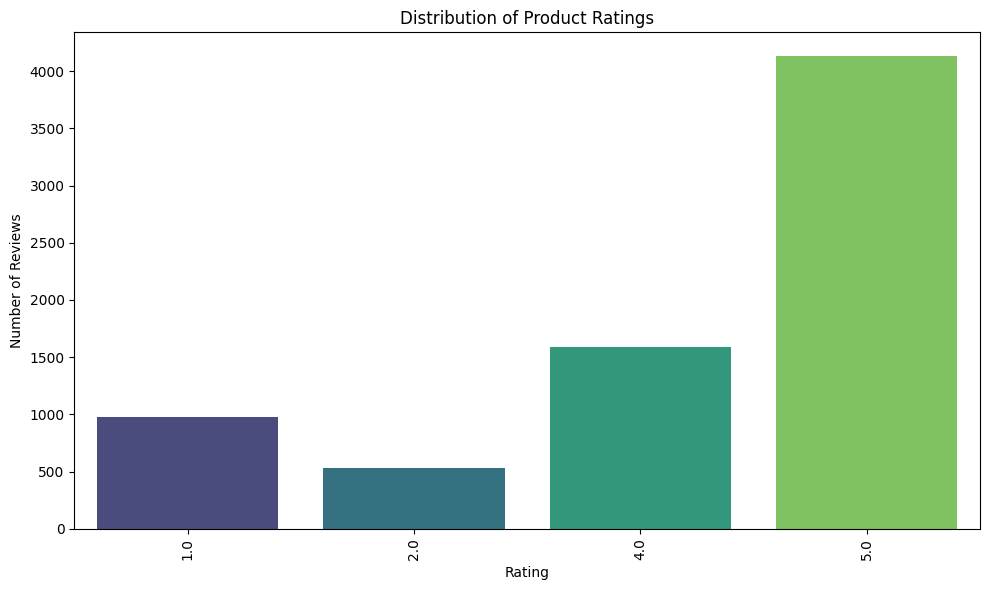

In [35]:
tqdm.pandas()

# Convert 'rating' to a numeric type, errors='coerce' will replace non-numeric values with NaN
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Drop rows with NaN values in 'rating' column
visual_df = df.dropna(subset=['rating'])

# Plotting the distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=visual_df, palette='viridis')
plt.title('Distribution of Product Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Most reviews seem to have a rating of 5, indicating a possible skew towards positive reviews.
There are fewer reviews with lower ratings, with a particularly low number of reviews with a rating of 2.0.

## Visualizing the distribution of ratings over time

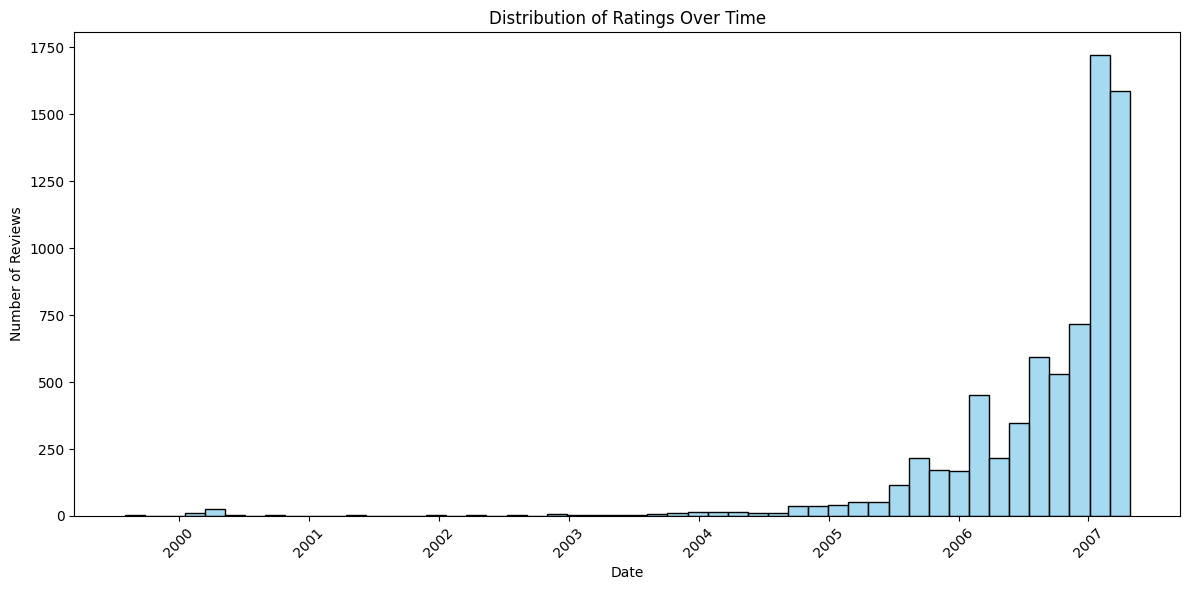

In [36]:
visual_df['date'] = pd.to_datetime(visual_df['date'], errors='coerce')

plt.figure(figsize=(12, 6))
sns.histplot(visual_df['date'], kde=False, bins=50, color='skyblue')
plt.title('Distribution of Ratings Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The chart illustrates the number of reviews over time, providing an overview of the review activity and its fluctuations.

## Visualizing the distribution of helpful votes

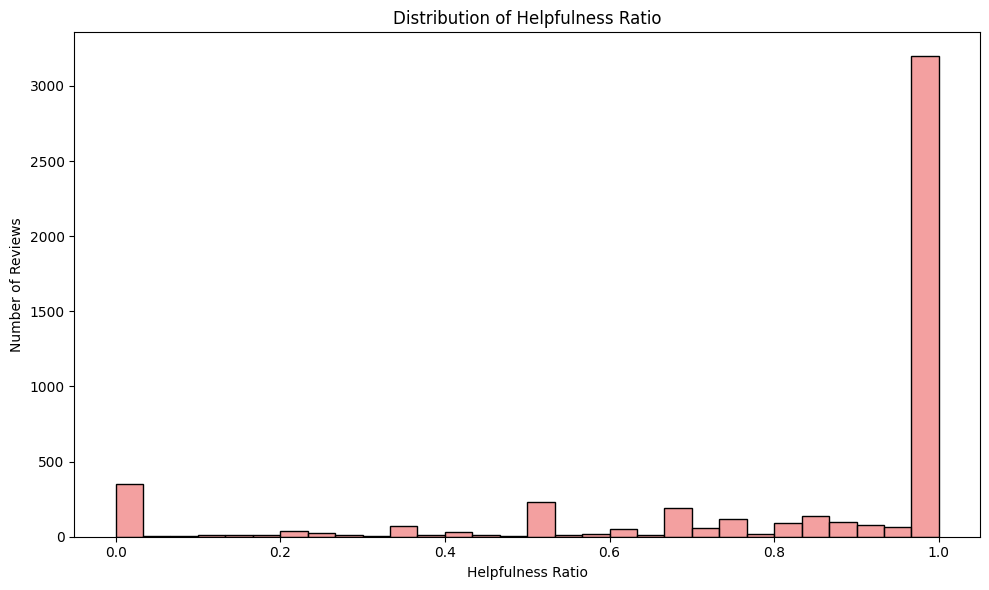

In [37]:
visual_df['helpful_votes'] = visual_df['helpful'].str.split(' of ', expand=True)[0]
visual_df['total_votes'] = visual_df['helpful'].str.split(' of ', expand=True)[1]

visual_df['helpful_votes'] = pd.to_numeric(visual_df['helpful_votes'], errors='coerce')
visual_df['total_votes'] = pd.to_numeric(visual_df['total_votes'], errors='coerce')

visual_df = visual_df.dropna(subset=['helpful_votes', 'total_votes'])

visual_df['helpfulness_ratio'] = visual_df['helpful_votes'] / visual_df['total_votes']

# Plotting the distribution of helpfulness ratio
plt.figure(figsize=(10, 6))
sns.histplot(visual_df['helpfulness_ratio'], kde=False, bins=30, color='lightcoral')
plt.title('Distribution of Helpfulness Ratio')
plt.xlabel('Helpfulness Ratio')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()

The histogram visualizes the distribution of the helpfulness ratio of reviews, which is calculated as the number of helpful votes divided by the total number of votes.

## Selecting the required columns

In [38]:
review_df = df[['unique_id', 'review_text', 'rating']]

review_df.head()

,unique_id,review_text,rating
0,4226,Expensive...and after three months of daily us...,1.0
1,4231,Meditation will do the same thing. Buy a tape ...,1.0
2,20954,"When I got this pedometer, I found that the in...",1.0
3,20962,The pedometer arrive held prisoner in a diffic...,1.0
4,22439,I was offered one of these while cycling and ...,2.0


## Create a new column 'sentiment' based on the rating

In [39]:
review_df['sentiment'] = review_df['rating'].apply(lambda x: 'positive' if x > 2.5 else 'negative')

review_df

,unique_id,review_text,rating,sentiment
0,4226,Expensive...and after three months of daily us...,1.0,negative
1,4231,Meditation will do the same thing. Buy a tape ...,1.0,negative
2,20954,"When I got this pedometer, I found that the in...",1.0,negative
3,20962,The pedometer arrive held prisoner in a diffic...,1.0,negative
4,22439,I was offered one of these while cycling and ...,2.0,negative
...,...,...,...,...
7220,"B0007MHF2M:aquadrene_review_5_stars:s._light_""...","This is an amazing product which, if taken as ...",5.0,positive
7221,B0007MHF2M:i_like_aquadrene_the_best_of_diuret...,I've used alot of different diuretic products ...,5.0,positive
7222,B000FKEUO2:glide_works_well_for_flossing_tight...,"As a dentist of over 20+ years experience, I h...",5.0,positive
7223,B000FKEUO2:cadillac_of_dental_floss:c._a._donh...,The best dental floss you can buy. Never spli...,5.0,positive


## Shuffelling the DataFrame

In [40]:
review_df = review_df.sample(frac=1).reset_index(drop=True)

review_df

,unique_id,review_text,rating,sentiment
0,B000FVEL7W:the_best:ronald_t._hicks,This the best product out there for preventing...,5.0,positive
1,B000GBID20:pleased_with_oral_b_vitality_sonic:...,I was looking for something less abrasive than...,4.0,positive
2,"B0009IK198:a_fine_shave:thomas_m._stevens_""mic...",I bought this razor to check out the foil shav...,4.0,positive
3,B000BPU3KG:best_one_there_is:sarah_j._moseley_...,I have fibromyalgia and my heating pads are my...,5.0,positive
4,"B000195OCO:just_trust_me...:shilo_irving_""u4ic...",This is one of the most all around fragrances ...,5.0,positive
...,...,...,...,...
7220,"B00012JWWE:lapdesk_works_great:jason_a._shaw_""...","of all the lapdesks we've tried, the posture r...",4.0,positive
7221,B00009V2R0:best_batteries_ever.:d._truong,these are the best batteries ever. i use my g...,5.0,positive
7222,B000FJVPSW:as_good_as_a_blow_up_pillow_can_be!...,I didn't expect this pillow to feel like my ho...,5.0,positive
7223,355598,I don't know what those other people were talk...,1.0,negative


## Plotting the distribution of the 'sentiment' column

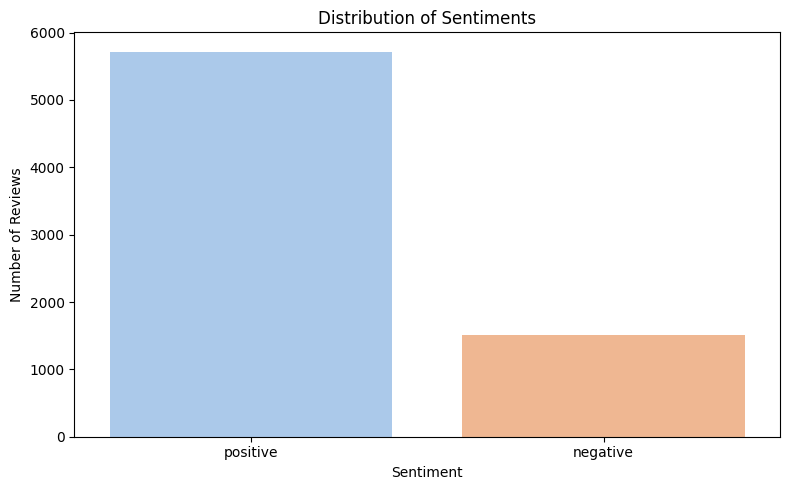

In [41]:
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=review_df, palette='pastel')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()

## Saving the final Preprocessed Riview data

In [42]:
review_df.to_csv('processed_data.csv')